# Identify canidate causal genes for pQTLs

In [1]:
import collections
import pandas
import numpy
import scipy.sparse
import tqdm
import hetio.readwrite

import hetmech.degree_weight

In [2]:
pqtl_df = pandas.read_table('pqtl.tsv')
loci_df = pandas.read_table('snps-to-locus-genes.tsv')
loci_df = loci_df.drop_duplicates()
snp_df = pqtl_df.merge(loci_df)
# Drop protein complexes
snp_df = snp_df.dropna(subset=['pqtl_entrez_id', 'locus_entrez_id'])
snp_df = snp_df[~snp_df.pqtl_entrez_id.str.contains(',')]
for col in 'pqtl_entrez_id', 'locus_entrez_id':
    snp_df[col] = snp_df[col].astype(int)
snp_df.head(2)

,snp,pqtl_gene,pqtl_entrez_id,neg_log10_p,gwas_source,locus_gene,locus_entrez_id,distance_to_snp
0,rs651007,SELE,6401,102.728,23300549,ABO,28,3217
1,rs651007,SELE,6401,102.728,23300549,SURF6,6838,50343


## Compute hetnet features

In [3]:
repo_url = 'https://github.com/dhimmel/hetionet'
commit = '6d26d15e9055b33b4fd97a180fa288e4f2060b96'
names = ['hetionet-v1.0'] + [f'hetionet-v1.0-perm-{i + 1}' for i in range(5)]    
paths = ['hetnet/json/hetionet-v1.0.json.bz2'] + [
    f'hetnet/permuted/json/{name}.json.bz2' for name in names[1:]
]
hetnets = collections.OrderedDict()
for name, path in zip(names, paths):
    url = f'{repo_url}/raw/{commit}/{path}'
    hetnets[name] = hetio.readwrite.read_graph(url)
list(hetnets)

['hetionet-v1.0',
 'hetionet-v1.0-perm-1',
 'hetionet-v1.0-perm-2',
 'hetionet-v1.0-perm-3',
 'hetionet-v1.0-perm-4',
 'hetionet-v1.0-perm-5']

In [4]:
DWPCs = collections.OrderedDict()
for name, graph in hetnets.items():
    metapath = graph.metagraph.metapath_from_abbrev('GpBPpG')
    row_ids, col_ids, dwpc_matrix, seconds = hetmech.degree_weight.dwpc(graph, metapath, damping=0.4, dense_threshold=0.6)
    DWPCs[name] = dwpc_matrix
    print(f'Computing DWPC matrix for the {metapath} metapath in {name} took {seconds:.1f} seconds')

Computing DWPC matrix for the GpBPpG metapath in hetionet-v1.0 took 5.1 seconds
Computing DWPC matrix for the GpBPpG metapath in hetionet-v1.0-perm-1 took 6.6 seconds
Computing DWPC matrix for the GpBPpG metapath in hetionet-v1.0-perm-2 took 6.5 seconds
Computing DWPC matrix for the GpBPpG metapath in hetionet-v1.0-perm-3 took 6.6 seconds
Computing DWPC matrix for the GpBPpG metapath in hetionet-v1.0-perm-4 took 6.6 seconds
Computing DWPC matrix for the GpBPpG metapath in hetionet-v1.0-perm-5 took 6.5 seconds


In [5]:
metapath.get_unicode_str()

'Gene–participates–Biological Process–participates–Gene'

In [6]:
# Scaling as per https://think-lab.github.io/d/193/#4
dwpc_scaler = DWPCs['hetionet-v1.0'].mean()
for name in list(DWPCs):
    matrix = DWPCs[name]
    if scipy.sparse.issparse(matrix):
        DWPCs[name] = matrix.multiply(dwpc_scaler ** -1).arcsinh()
    else:
        DWPCs[name] = numpy.arcsinh(matrix / dwpc_scaler)

### Unused code

In [7]:
# pdwpc_matrices = list(DWPCs.values())[1:]
# pdwpc_mean = sum(pdwpc_matrices) / len(pdwpc_matrices)
# pdwpc_mean[:6, :6].toarray()

In [8]:
# https://stackoverflow.com/a/24010418/4651668
# numpy.std(pdwpc_matrices, axis=0, ddof=1)

In [9]:
# def permutation_adjust(dwpc_matrices):
#     dwpc, *pdwpc_mats = dwpc_matrices
#     pdwpc = sum(pdwpc_mats) / len(pdwpc_mats)
#     sddwpc = (1 / (len(pdwpc_mats) - 1) * sum((x - pdwpc) ** 2 for x in pdwpc_mats)) ** 0.5
#     rdwpc = dwpc - pdwpc
#     zdwpc = rdwpc / sddwpc
#     return rdwpc, zdwpc

# # This took forever
# # rdwpc, zdwpc = permutation_adjust(DWPCs.values())

## Combine DWPC values with gene-pairs of interest

In [10]:
pair_df = snp_df[['pqtl_entrez_id', 'locus_entrez_id']].drop_duplicates()
row_to_position = {row: i for i, row in enumerate(row_ids)}
col_to_position = {col: i for i, col in enumerate(col_ids)}
pair_df['row_index'] = pair_df.pqtl_entrez_id.map(row_to_position)
pair_df['col_index'] = pair_df.locus_entrez_id.map(col_to_position)
pair_df = pair_df.dropna(subset=['row_index', 'col_index'])
for col in 'row_index', 'col_index':
    pair_df[col] = pair_df[col].astype(int)
pair_df.tail(2)

,pqtl_entrez_id,locus_entrez_id,row_index,col_index
131459,354,79290,250,12434
131460,354,26095,250,8756


In [11]:
rows = list()
indices = list(zip(pair_df.row_index, pair_df.col_index))
for i, j in tqdm.tqdm_notebook(indices):
    row = {
        'row_index': i,
        'col_index': j,
    }
    for name, matrix in DWPCs.items():
        row[name] = matrix[i, j]
    rows.append(row)
dwpc_df = (
    pair_df
    .merge(pandas.DataFrame(rows))
    .drop(columns=['row_index', 'col_index'])
    .set_index(['pqtl_entrez_id', 'locus_entrez_id'])
)
dwpc_df.tail(2)

HBox(children=(IntProgress(value=0, max=74867), HTML(value='')))

hetionet-v1.0  hetionet-v1.0-perm-1  \
pqtl_entrez_id locus_entrez_id                                        
354            79290                      0.0              1.973110   
               26095                      0.0              2.491907   

                                hetionet-v1.0-perm-2  hetionet-v1.0-perm-3  \
pqtl_entrez_id locus_entrez_id                                               
354            79290                             0.0                   0.0   
               26095                             0.0                   0.0   

                                hetionet-v1.0-perm-4  hetionet-v1.0-perm-5  
pqtl_entrez_id locus_entrez_id                                              
354            79290                        2.183583                   0.0  
               26095                        0.000000                   0.0

In [12]:
perm_df = dwpc_df.iloc[:, 1:]
r_dwpc = dwpc_df.iloc[:, 0] - perm_df.mean(axis='columns')
z_dwpc = r_dwpc / perm_df.std(axis='columns')
dwpc_df['r-dwpc'] = r_dwpc
dwpc_df['z-dwpc'] = z_dwpc
dwpc_df.head(2)

hetionet-v1.0  hetionet-v1.0-perm-1  \
pqtl_entrez_id locus_entrez_id                                        
6401           28                         0.0                   0.0   
               6838                       0.0                   0.0   

                                hetionet-v1.0-perm-2  hetionet-v1.0-perm-3  \
pqtl_entrez_id locus_entrez_id                                               
6401           28                           3.381078                   0.0   
               6838                         0.000000                   0.0   

                                hetionet-v1.0-perm-4  hetionet-v1.0-perm-5  \
pqtl_entrez_id locus_entrez_id                                               
6401           28                           1.838338                   0.0   
               6838                         2.637118                   0.0   

                                  r-dwpc    z-dwpc  
pqtl_entrez_id locus_entrez_id                      
6401           28              -1.043883 -0.682309  
               6838            -0.527424 -0.447214

In [13]:
candidate_df = snp_df.merge(dwpc_df.reset_index())
candidate_df = candidate_df.sort_values(['gwas_source', 'snp', 'pqtl_gene', 'z-dwpc'], ascending=[True, True, True, False])
candidate_df.head(2)

,snp,pqtl_gene,pqtl_entrez_id,neg_log10_p,gwas_source,locus_gene,locus_entrez_id,distance_to_snp,hetionet-v1.0,hetionet-v1.0-perm-1,hetionet-v1.0-perm-2,hetionet-v1.0-perm-3,hetionet-v1.0-perm-4,hetionet-v1.0-perm-5,r-dwpc,z-dwpc
52332,rs1003645,CCL23,6368,19.64,10.1101/086793,TBC1D3B,414059,152437,3.310107,0.0,0.0,0.0,0.0,0.0,3.310107,inf
52336,rs1003645,CCL23,6368,19.64,10.1101/086793,TBC1D3B,414060,152437,3.310107,0.0,0.0,0.0,0.0,0.0,3.310107,inf


In [14]:
candidate_df.to_csv('canidates-GpBPpG.tsv', sep='\t', index=False)

### Plot certain DWPC metrics

In [15]:
%matplotlib inline

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcead1efe48>]],
      dtype=object)

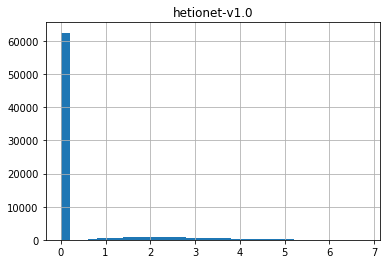

In [16]:
dwpc_df[['hetionet-v1.0']].hist(bins=numpy.arange(0, 7, 0.2))

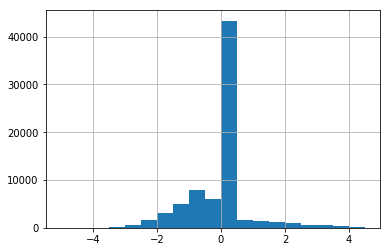

In [17]:
dwpc_df['r-dwpc'].hist(bins=numpy.arange(-5, 5, 0.5))

## Potential candidates of interest

In [18]:
groups = candidate_df.groupby(['gwas_source', 'snp', 'pqtl_gene'])
groups = [df for i, df in groups]

In [19]:
groups[2]

,snp,pqtl_gene,pqtl_entrez_id,neg_log10_p,gwas_source,locus_gene,locus_entrez_id,distance_to_snp,hetionet-v1.0,hetionet-v1.0-perm-1,hetionet-v1.0-perm-2,hetionet-v1.0-perm-3,hetionet-v1.0-perm-4,hetionet-v1.0-perm-5,r-dwpc,z-dwpc
64160,rs10127775,MAP2K4,6416,13.165,10.1101/086793,AGT,183,542481,3.990344,2.816258,3.023142,3.417487,2.757052,3.625282,0.862500,2.271166
64170,rs10127775,MAP2K4,6416,13.165,10.1101/086793,ACTA1,58,725944,1.970243,1.608559,1.084304,2.807521,1.100928,1.790712,0.291838,0.414924
64174,rs10127775,MAP2K4,6416,13.165,10.1101/086793,CCSAP,126731,816748,1.450256,2.115290,2.262003,1.088473,1.218173,2.352855,-0.357103,-0.590469
64150,rs10127775,MAP2K4,6416,13.165,10.1101/086793,GALNT2,2590,102052,0.000000,0.000000,0.000000,0.000000,1.569408,1.579005,-0.629683,-0.730291
64154,rs10127775,MAP2K4,6416,13.165,10.1101/086793,COG2,22796,482447,0.000000,0.000000,1.266988,1.945686,0.000000,1.705555,-0.983646,-1.057306
64178,rs10127775,MAP2K4,6416,13.165,10.1101/086793,RAB4A,5867,854148,0.000000,0.000000,1.601961,3.545658,1.571794,1.671382,-1.678159,-1.334973
64176,rs10127775,MAP2K4,6416,13.165,10.1101/086793,ARV1,64801,818939,0.000000,2.898118,1.110327,1.779314,1.801071,0.000000,-1.517766,-1.427216
64158,rs10127775,MAP2K4,6416,13.165,10.1101/086793,TAF5L,27097,533995,0.000000,2.775774,2.017408,1.418183,1.596730,0.000000,-1.561619,-1.534547
64166,rs10127775,MAP2K4,6416,13.165,10.1101/086793,NUP133,55746,651701,0.000000,1.672613,2.355166,2.032465,1.459029,2.832701,-2.070395,-3.786888
64152,rs10127775,MAP2K4,6416,13.165,10.1101/086793,PGBD5,79605,154440,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN


In [20]:
groups[7]

,snp,pqtl_gene,pqtl_entrez_id,neg_log10_p,gwas_source,locus_gene,locus_entrez_id,distance_to_snp,hetionet-v1.0,hetionet-v1.0-perm-1,hetionet-v1.0-perm-2,hetionet-v1.0-perm-3,hetionet-v1.0-perm-4,hetionet-v1.0-perm-5,r-dwpc,z-dwpc
79435,rs10494745,HPX,3263,66.571,10.1101/086793,CFH,3075,170823,3.835351,1.103875,2.259525,1.892096,1.491275,2.759793,1.934039,2.993722
79431,rs10494745,HPX,3263,66.571,10.1101/086793,CFHR1,3078,86138,2.640555,0.000000,0.000000,1.489131,0.000000,2.361645,1.870400,1.702267
79430,rs10494745,HPX,3263,66.571,10.1101/086793,CFHR5,81494,59229,2.593941,1.415964,1.848684,3.165930,0.000000,0.000000,1.307826,0.976477
79439,rs10494745,HPX,3263,66.571,10.1101/086793,DENND1B,163486,586421,2.148065,2.500236,2.429358,1.716967,0.000000,1.097558,0.599241,0.577202
79438,rs10494745,HPX,3263,66.571,10.1101/086793,CRB1,23418,349877,0.000000,0.000000,2.917271,2.083965,0.000000,0.000000,-1.000247,-0.713966
79432,rs10494745,HPX,3263,66.571,10.1101/086793,F13B,2165,120864,0.000000,0.000000,0.000000,0.000000,1.553713,1.960412,-0.702825,-0.722279
79441,rs10494745,HPX,3263,66.571,10.1101/086793,LHX9,56956,993575,0.000000,2.783547,1.668324,1.105394,1.186183,0.000000,-1.348690,-1.337773
79437,rs10494745,HPX,3263,66.571,10.1101/086793,KCNT2,343450,309102,0.000000,0.000000,1.513038,2.791460,1.674941,2.179412,-1.631770,-1.569549
79434,rs10494745,HPX,3263,66.571,10.1101/086793,ASPM,259266,165801,0.000000,1.751571,3.322955,2.954039,2.906937,3.273044,-2.841709,-4.461293
79428,rs10494745,HPX,3263,66.571,10.1101/086793,CFHR4,10877,645,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN


In [21]:
groups[8]

,snp,pqtl_gene,pqtl_entrez_id,neg_log10_p,gwas_source,locus_gene,locus_entrez_id,distance_to_snp,hetionet-v1.0,hetionet-v1.0-perm-1,hetionet-v1.0-perm-2,hetionet-v1.0-perm-3,hetionet-v1.0-perm-4,hetionet-v1.0-perm-5,r-dwpc,z-dwpc
56895,rs10737680,CFH,3075,35.89,10.1101/086793,CFHR5,81494,267231,5.990524,0.000000,0.000000,0.00000,3.185837,0.000000,5.353357,3.757401
56889,rs10737680,CFH,3075,35.89,10.1101/086793,CFHR1,3078,109432,5.346501,2.067891,0.000000,0.00000,0.000000,2.364166,4.460089,3.660971
56905,rs10737680,CFH,3075,35.89,10.1101/086793,DENND1B,163486,794423,3.378203,1.457972,0.000000,0.00000,0.000000,2.293656,2.627877,2.458109
56897,rs10737680,CFH,3075,35.89,10.1101/086793,F13B,2165,328866,0.000000,0.000000,0.000000,0.00000,0.000000,3.679855,-0.735971,-0.447214
56903,rs10737680,CFH,3075,35.89,10.1101/086793,CRB1,23418,557879,0.000000,1.923703,0.000000,0.00000,0.000000,0.000000,-0.384741,-0.447214
56899,rs10737680,CFH,3075,35.89,10.1101/086793,ASPM,259266,373803,0.000000,1.316198,1.160243,1.19434,1.991470,2.991465,-1.730743,-2.214880
56883,rs10737680,CFH,3075,35.89,10.1101/086793,CFH,3075,37179,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,NaN
56885,rs10737680,CFH,3075,35.89,10.1101/086793,CFHR3,10878,64470,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,NaN
56887,rs10737680,CFH,3075,35.89,10.1101/086793,KCNT2,343450,101100,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,NaN
56891,rs10737680,CFH,3075,35.89,10.1101/086793,CFHR4,10877,139916,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,NaN
